## Another Example

In [1]:
# setup

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
import qiskit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

# SciPy minimizer routine
from scipy.optimize import minimize

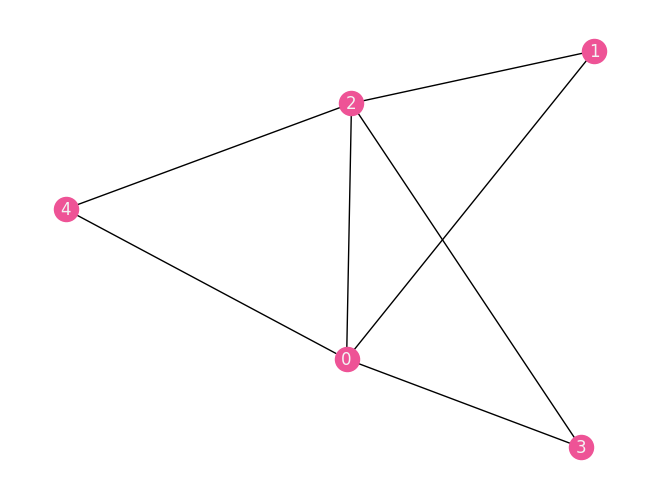

In [2]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1), (2, 1, 1), (2, 3, 1), (2, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, 
    with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend = AerSimulator()
backend.name
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


### Adiabatic Process

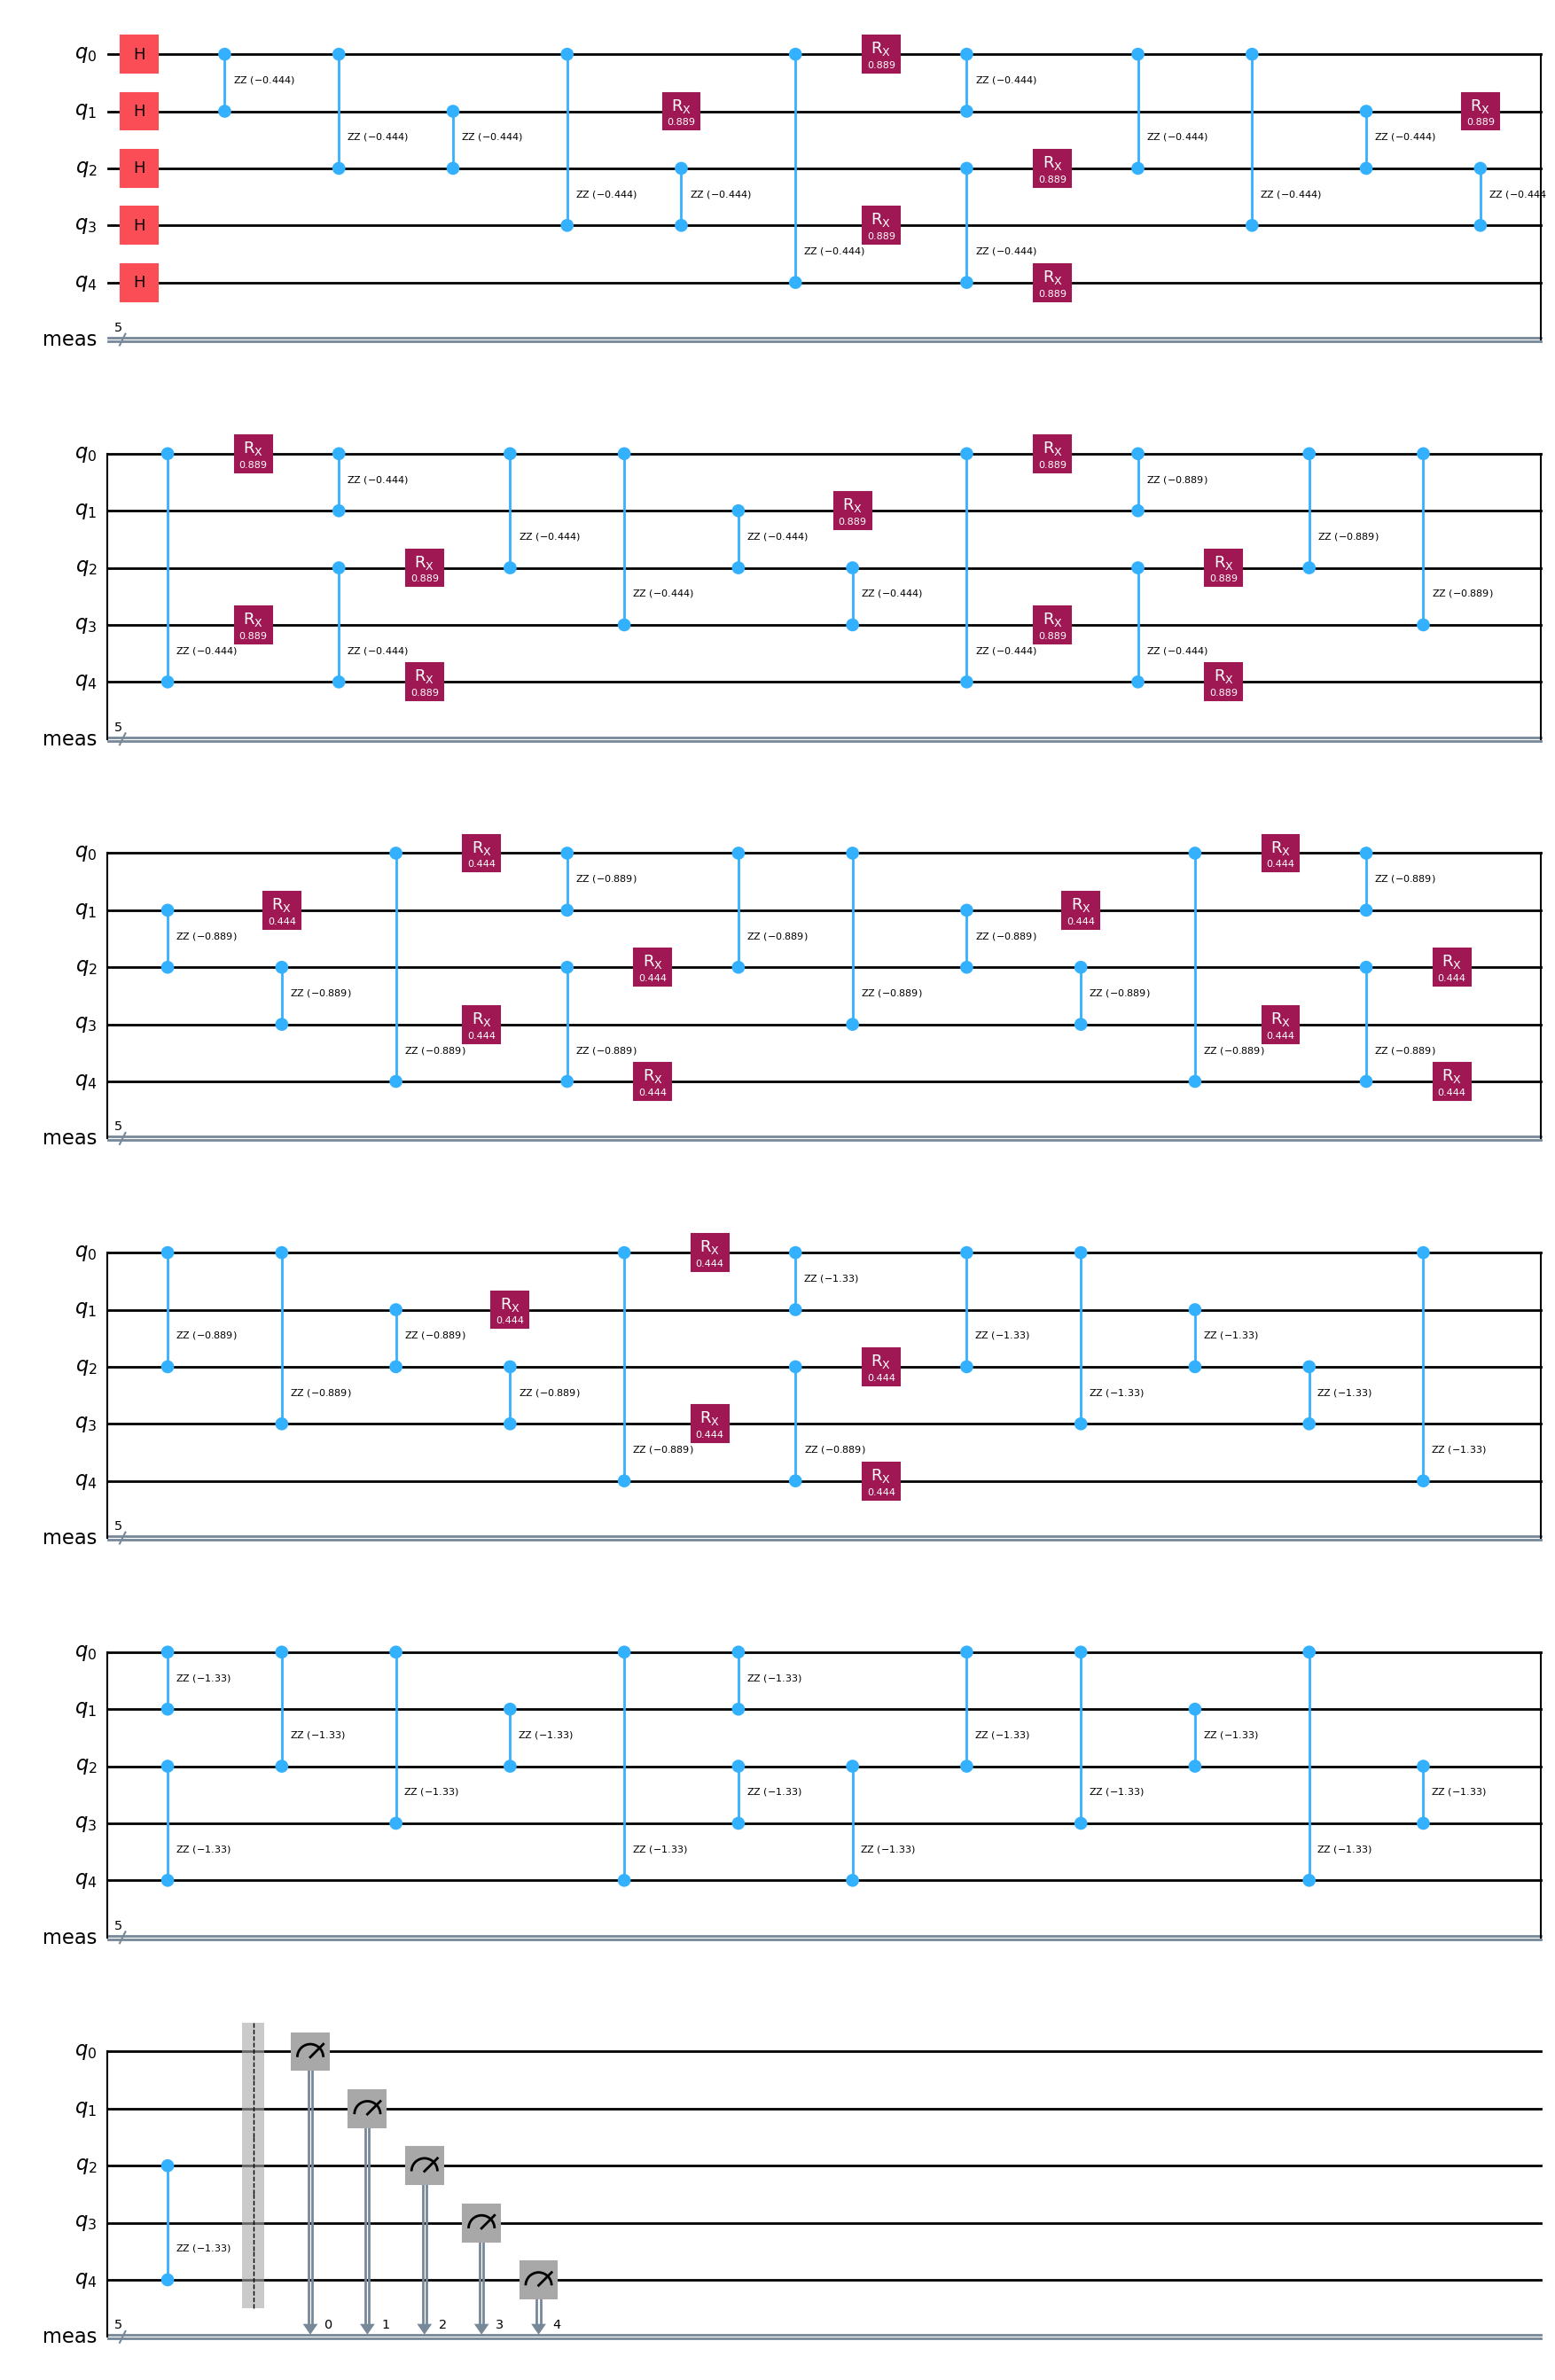

In [4]:
# Try 
T=3
N=3

# Problem to Hamiltonian operator
H_C = SparsePauliOp.from_list([("IIIZZ", -1), ("IIZIZ", -1), ("IZIIZ", -1), ("ZIIIZ", -1), 
                               ("IIZZI", -1), ("IZZII", -1), ("ZIZII", -1)])
# QAOA ansatz circuit repeating e^{H_C} and e^{H_M} "reps" times with gamma and beta parameters
ansatz = QAOAAnsatz(H_C, reps=T*N)

params = []

# parameters for H_M part of ansatz
for i in range(1, T+1):
    for j in range(N):
        params.append(2 * (1 - i * 1.0 / N) / T)  # beta R_X(2 \theta) 

# parameters for H_C part of ansatz
for i in range(1, T+1):
    for j in range(N):
        params.append(2 * (i * 1.0 / N) / T)      # gamma R_Z(2 \theta)



qc = ansatz.assign_parameters(params)
qc.measure_all()
qc_isa = pm.run(qc)

qc_isa.decompose(reps=0).draw(output='mpl')

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


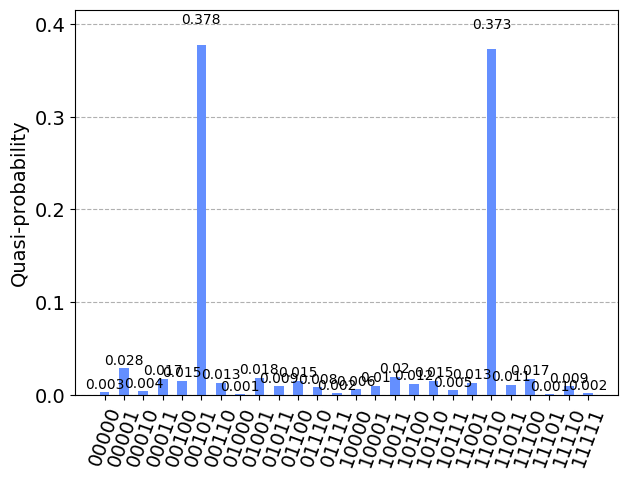

In [5]:
session = Session(backend=backend)
sampler = Sampler(session=session)
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
session.close()
plot_distribution(samp_dist)


### QAOA

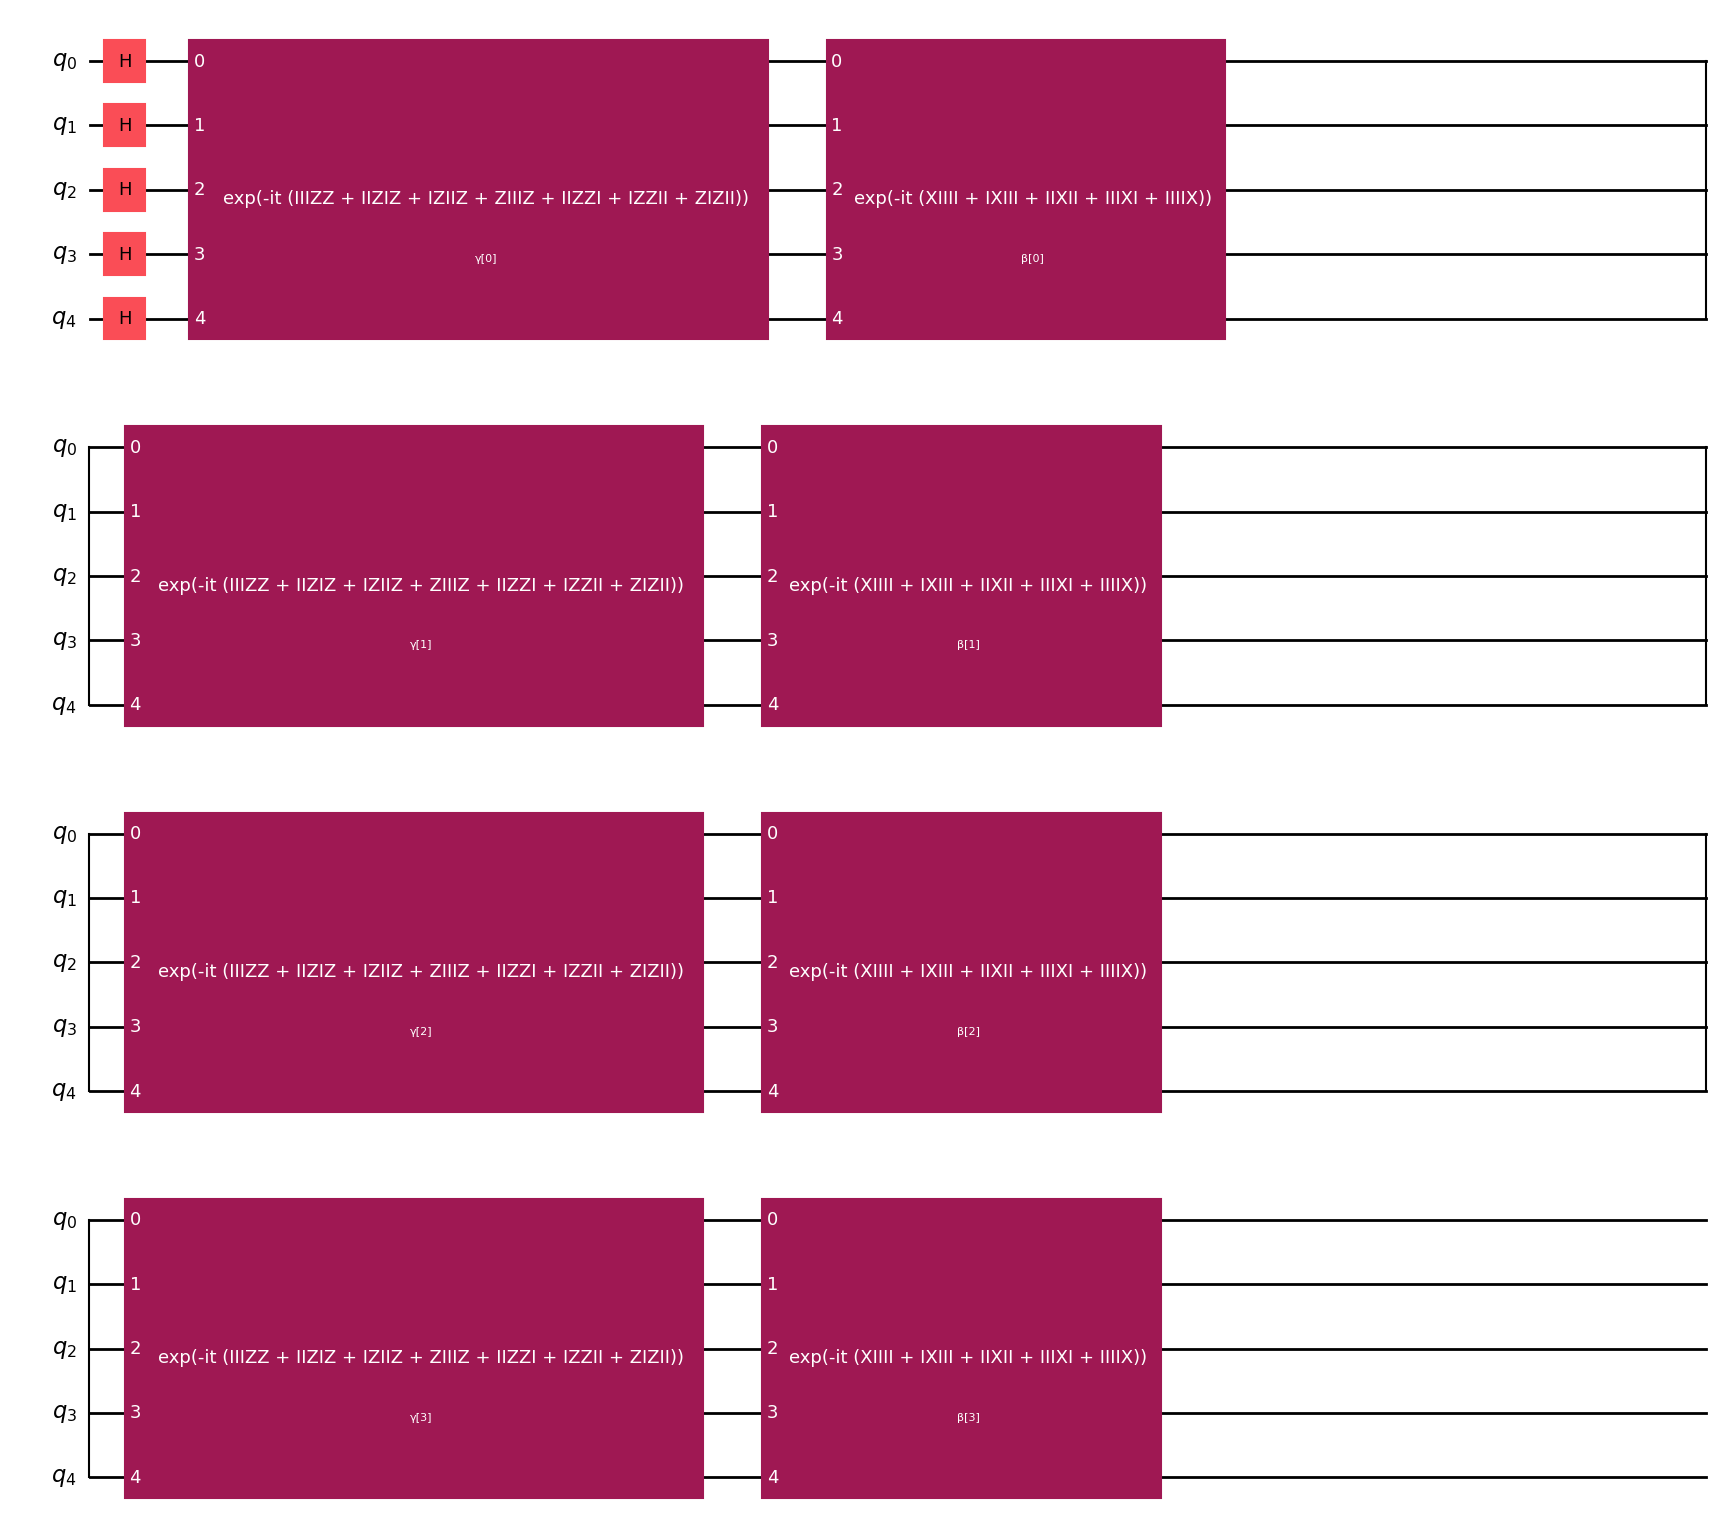

In [6]:
M = 4

# Problem to Hamiltonian operator
H_C = SparsePauliOp.from_list([("IIIZZ", -1), ("IIZIZ", -1), ("IZIIZ", -1), ("ZIIIZ", -1),
                               ("IIZZI", -1), ("IZZII", -1), ("ZIZII", -1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(H_C, reps=M)

ansatz.decompose(reps=1).draw(output='mpl')

In [7]:
# transpile ansatz according to backend instruction set architecture (ISA)
# also apply to SparsePauliOp H_C

ansatz_isa = pm.run(ansatz)
H_C_isa = H_C.apply_layout(ansatz_isa.layout)
H_C_isa

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZIZII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])

In [8]:
def cost_func1(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    qc = ansatz.assign_parameters(params)
    result = estimator.run(pubs=[(qc, hamiltonian)]).result()
    cost = result[0].data.evs
    return -cost        # minimize -cost == maximum cost

In [9]:
# define EstimatorV2 and SamplerV2

# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10_000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 10_000
sampler.options.dynamical_decoupling.enable = True

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [10]:
import numpy as np
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [11]:
res = minimize(cost_func1, x0, args=(ansatz_isa, H_C_isa, estimator), method="COBYLA")

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 10000, 'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [12]:
res.x

array([3.41759996, 1.84847587, 2.44956282, 3.57967883, 4.93203644,
       2.26433988, 3.62264914, 5.09463038])

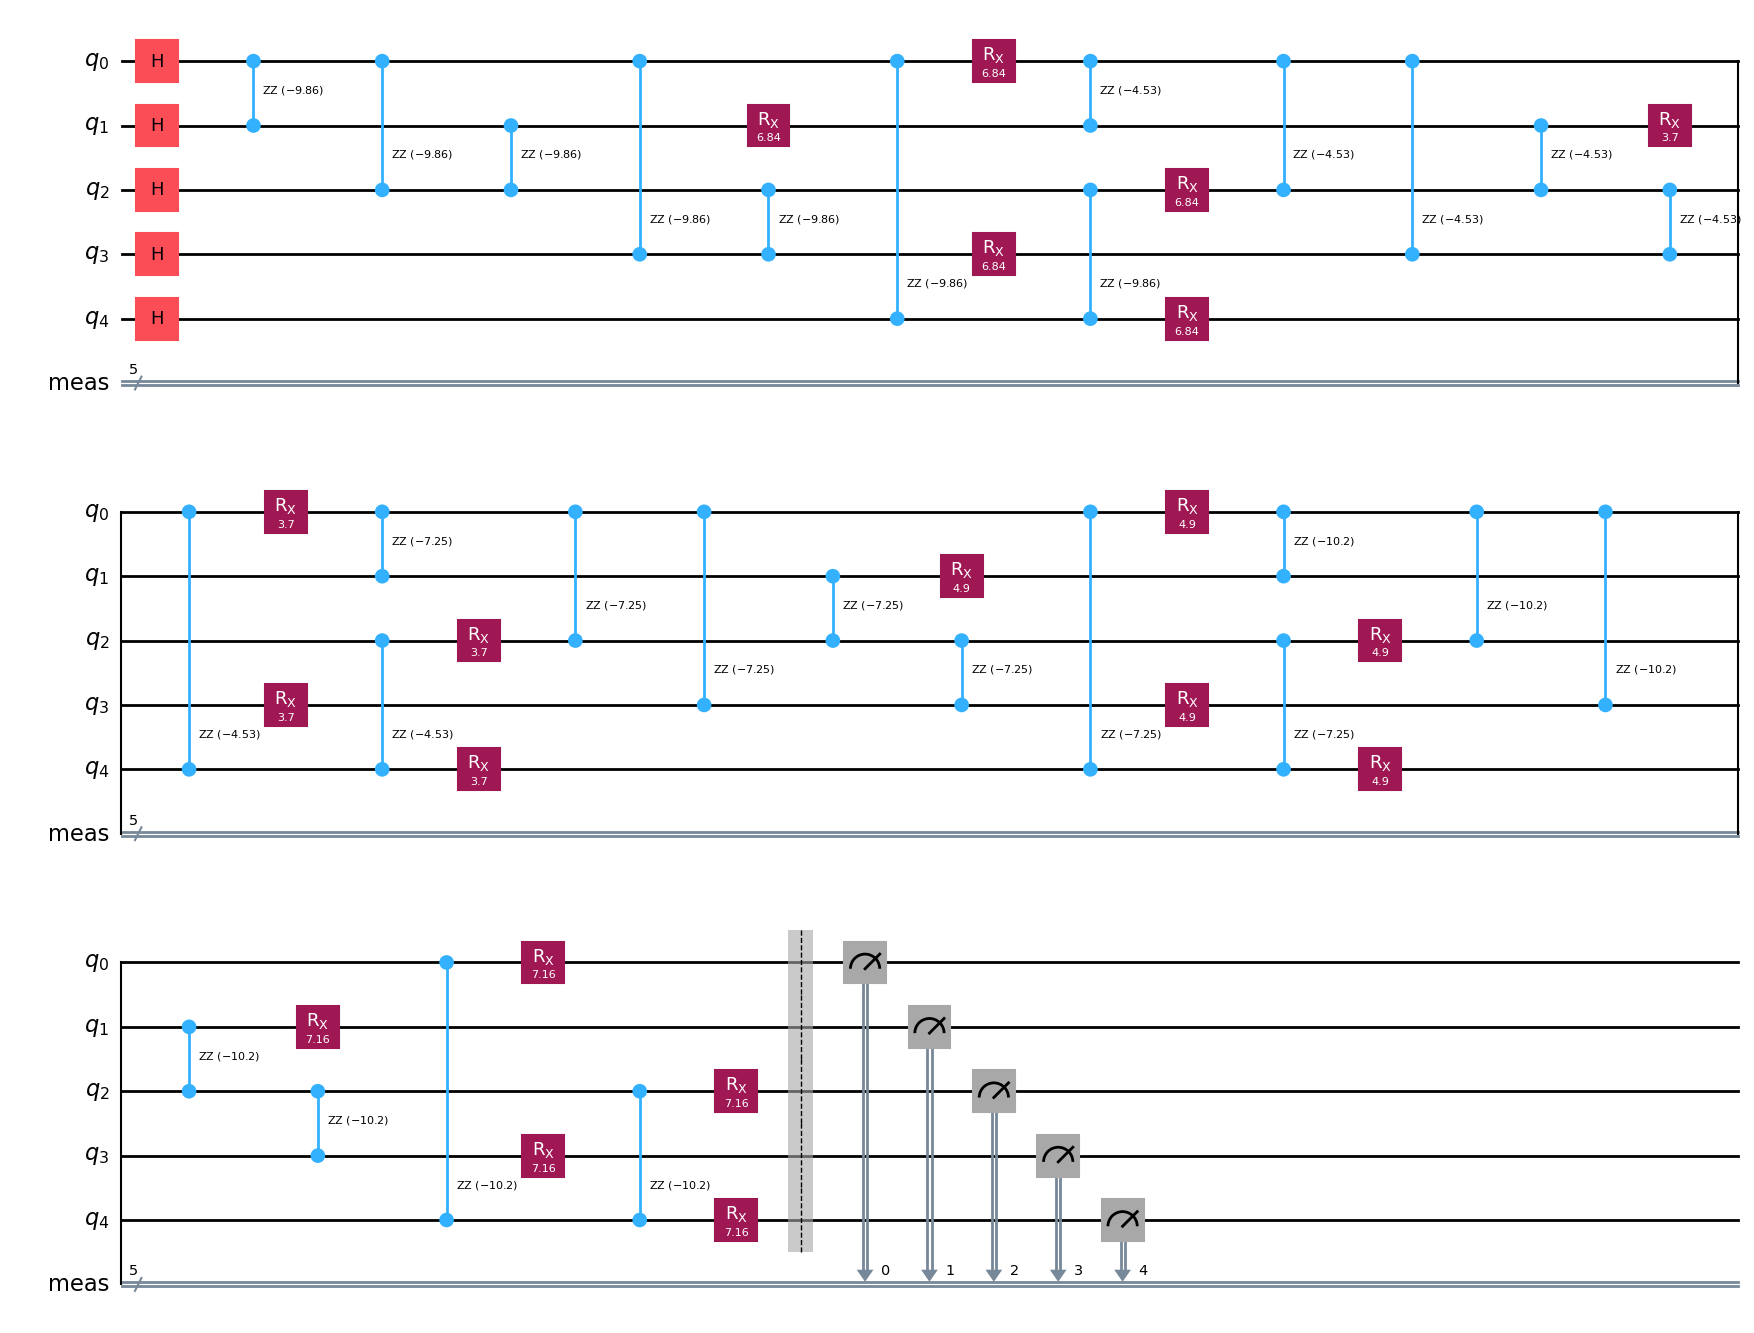

In [13]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl")

In [14]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


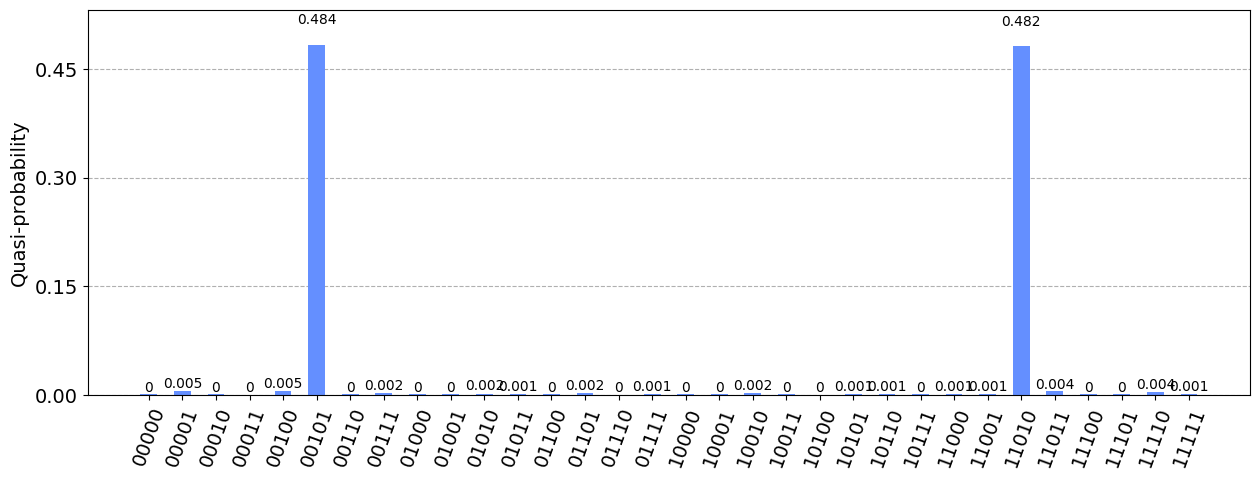

In [15]:
plot_distribution(samp_dist, figsize=(15, 5))

In [16]:
qiskit.__version__

'1.0.2'